## Model Building

### Build model for predicting price of appartments

In [264]:
#import packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [265]:
#Read data
df = pd.read_csv('mubawab_listings_eda.csv')

In [314]:
df.head()

,Type,Localisation,Price,Area,Rooms,Bedrooms,Bathrooms,Floor,Other_tags,Price_m2,Current_state,Age
0,Appartements,Anfa,1230000,86.0,3.0,2.0,2.0,1.0,"['Bon état', '10-20 ans']",14302.325581,Bon état,10-20 ans
1,Appartements,La Gironde,900000,86.0,3.0,2.0,1.0,5.0,"['Bon état', '10-20 ans']",10465.116279,Bon état,10-20 ans
2,Appartements,Bourgogne Ouest,2400000,180.0,5.0,3.0,3.0,3.0,"['Bon état', '10-20 ans']",13333.333333,Bon état,10-20 ans
3,Appartements,Les princesses,1550000,120.0,5.0,3.0,2.0,5.0,"['Bon état', '5-10 ans']",12916.666667,Bon état,5-10 ans
4,Appartements,Bourgogne Ouest,1450000,113.0,4.0,3.0,2.0,1.0,"['Bon état', '10-20 ans']",12831.858407,Bon état,10-20 ans


In [267]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           892 non-null    object 
 1   Localisation   892 non-null    object 
 2   Price          892 non-null    int64  
 3   Area           892 non-null    float64
 4   Rooms          892 non-null    float64
 5   Bedrooms       892 non-null    float64
 6   Bathrooms      892 non-null    float64
 7   Floor          892 non-null    float64
 8   Other_tags     892 non-null    object 
 9   Price_m2       892 non-null    float64
 10  Current_state  855 non-null    object 
 11  Age            653 non-null    object 
dtypes: float64(6), int64(1), object(5)
memory usage: 83.8+ KB


In [319]:
#Select columns to keep for modeling
cols_to_keep = ['Type','Localisation','Area','Rooms','Bedrooms','Bathrooms','Floor','Current_state','Age','Price']
df_model = df[cols_to_keep]

In [320]:
#Data preprocessing : Missing values
display(df_model.isna().sum())

Type               0
Localisation       0
Area               0
Rooms              0
Bedrooms           0
Bathrooms          0
Floor              0
Current_state     37
Age              239
Price              0
dtype: int64

In [321]:
#Split dataframe into Features and Target Variable

features = ['Type','Localisation','Area','Rooms','Bedrooms','Bathrooms','Floor','Current_state','Age']
X = df_model[features]
y = df_model['Price'].values 

In [322]:
#Encode ordinal variables

X.loc[:,'Current_state'] = X['Current_state'].replace(np.nan,0).replace('Nouveau',1).replace('Bon état',2).replace('À rénover',3)
X.loc[:,'Age'] = X['Age'].replace(np.nan,0).replace("Moins d'un an",1).replace("1-5 ans",2).replace("5-10 ans",3).replace("10-20 ans",4).replace("20-30 ans",5).replace("30-50 ans",6).replace("50-70 ans",7)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [323]:
#Encode categorical variables remaining
X_dummies = pd.get_dummies(X)

In [324]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [325]:
#Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_dummies,y,test_size = 0.3,random_state = 123)

In [326]:
#Scale the features using robust_scaler
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test),columns = X_test.columns)

In [327]:
#define function to evaluate linear models
def evaluate_linear_model(X_train,y_train,X_test,y_test,reg,grid = False):
    
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)
    RMSE_error_train = np.sqrt(MSE(y_train,reg.predict(X_train)))
    RMSE_error = np.sqrt(MSE(y_test,y_pred))
    MAPE_train = np.median(MAPE(y_train,reg.predict(X_train),multioutput = 'raw_values'))
    MAPE_test = np.median(MAPE(y_test,y_pred, multioutput = 'raw_values'))
    
    if grid:
        print(f'Best estimator parameters : {reg.best_params_}')
        reg = reg.best_estimator_
        
    
    print(f'train RMSE : {RMSE_error_train:.2f}')
    print(f'test RMSE : {RMSE_error:.2f}')
    print(f'train MAPE : {MAPE_train:.4f}')
    print(f'test MAPE : {MAPE_test:.4f}')
    print(f'Training set score (R^2): {reg.score(X_train,y_train):.2f}')
    print(f'Test set score (R^2): {reg.score(X_test,y_test):.2f}')
    coef_matrix = pd.DataFrame(np.hstack([reg.intercept_,reg.coef_]).reshape(1,-1),columns = np.hstack(['Intercept',X_train.columns]))
    display(coef_matrix)
    
    error_matrix = np.array([y_test,(y_test-y_pred)/y_test])

    fig,axes = plt.subplots(2,2,figsize = (20,16))
    
    ax1 = plt.subplot2grid((2,2),(0,0),rowspan=2)
    ax2 = plt.subplot2grid((2,2),(0,1),colspan = 1)
    ax3 = plt.subplot2grid((2,2),(1,1),colspan = 1)
    
    g = sns.barplot(y = coef_matrix.columns,x = coef_matrix.iloc[0,:] ,color = cust_pal[5],ax=ax1)
    ax1.tick_params('x',rotation = 45)
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(int(x),',')))
    

    g = sns.regplot(x = y_test,y = reg.predict(X_test),color = cust_pal[5],ax=ax2)
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(int(x),',')))
    g = sns.histplot(x = error_matrix[1,:],bins = 50,kde = True, color = cust_pal[5],ax = ax3)
    ax3.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(x,'%')))
    #g = sns.jointplot(x = error_matrix[0,:], y= error_matrix[1,:],color = cust_pal[5], height = 8, ratio = 5)
    
    plt.tight_layout()
    plt.show()
    
cust_pal = sns.color_palette(sns.light_palette('#0d874b',10))

train RMSE : 1977125.24
test RMSE : 2240794.49
train MAPE : 0.2211
test MAPE : 0.2395
Training set score (R^2): 0.94
Test set score (R^2): 0.90


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,...,Localisation_Maârif Extension,Localisation_Mers Sultan,Localisation_Oasis,Localisation_Oulfa,Localisation_Palmier,Localisation_Polo,Localisation_Racine,Localisation_Sidi Maarouf,Localisation_Triangle d'Or,Localisation_Val Fleury
0,1.069277e+06,12612.650753,-30130.770216,-66320.65321,474342.89429,-29803.882502,-48044.998099,-130769.886572,-410218.079017,410218.079017,...,-521546.73958,-411716.160718,-550196.19917,-1.062128e+06,-357975.523402,-3.200580e+06,220434.092695,-1.169046e+06,-72703.058976,-428174.193918


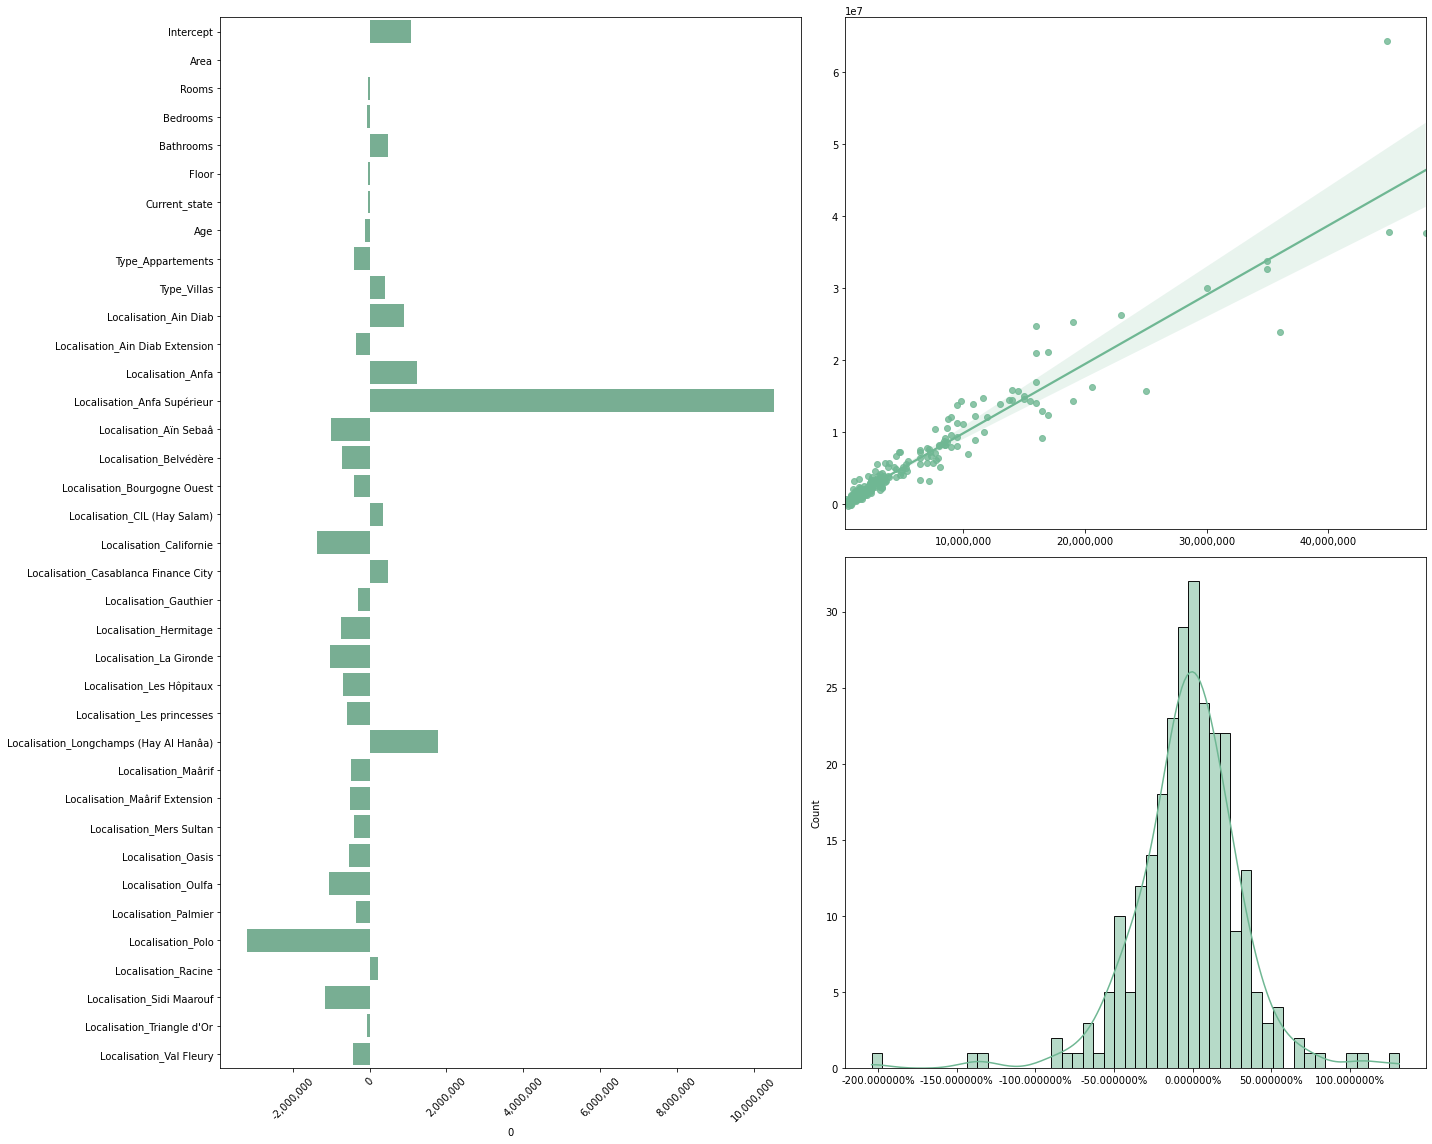

In [328]:
#Evaluate multivariate ols linear regression

linear_regression = LinearRegression()
evaluate_linear_model(X_train,y_train,X_test,y_test,linear_regression)

Best estimator parameters : {'alpha': 0.1}
train RMSE : 1977178.33
test RMSE : 2242823.78
train MAPE : 0.2208
test MAPE : 0.2394
Training set score (R^2): 0.94
Test set score (R^2): 0.90


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,...,Localisation_Maârif Extension,Localisation_Mers Sultan,Localisation_Oasis,Localisation_Oulfa,Localisation_Palmier,Localisation_Polo,Localisation_Racine,Localisation_Sidi Maarouf,Localisation_Triangle d'Or,Localisation_Val Fleury
0,1.070004e+06,12624.481922,-29515.820103,-67446.042987,472976.139422,-29739.808254,-47721.899954,-131045.107423,-414993.679236,414993.679236,...,-514975.923963,-400425.144856,-548639.672224,-1.052278e+06,-350041.917419,-3.184067e+06,225581.381827,-1.164476e+06,-66767.116841,-420076.234809


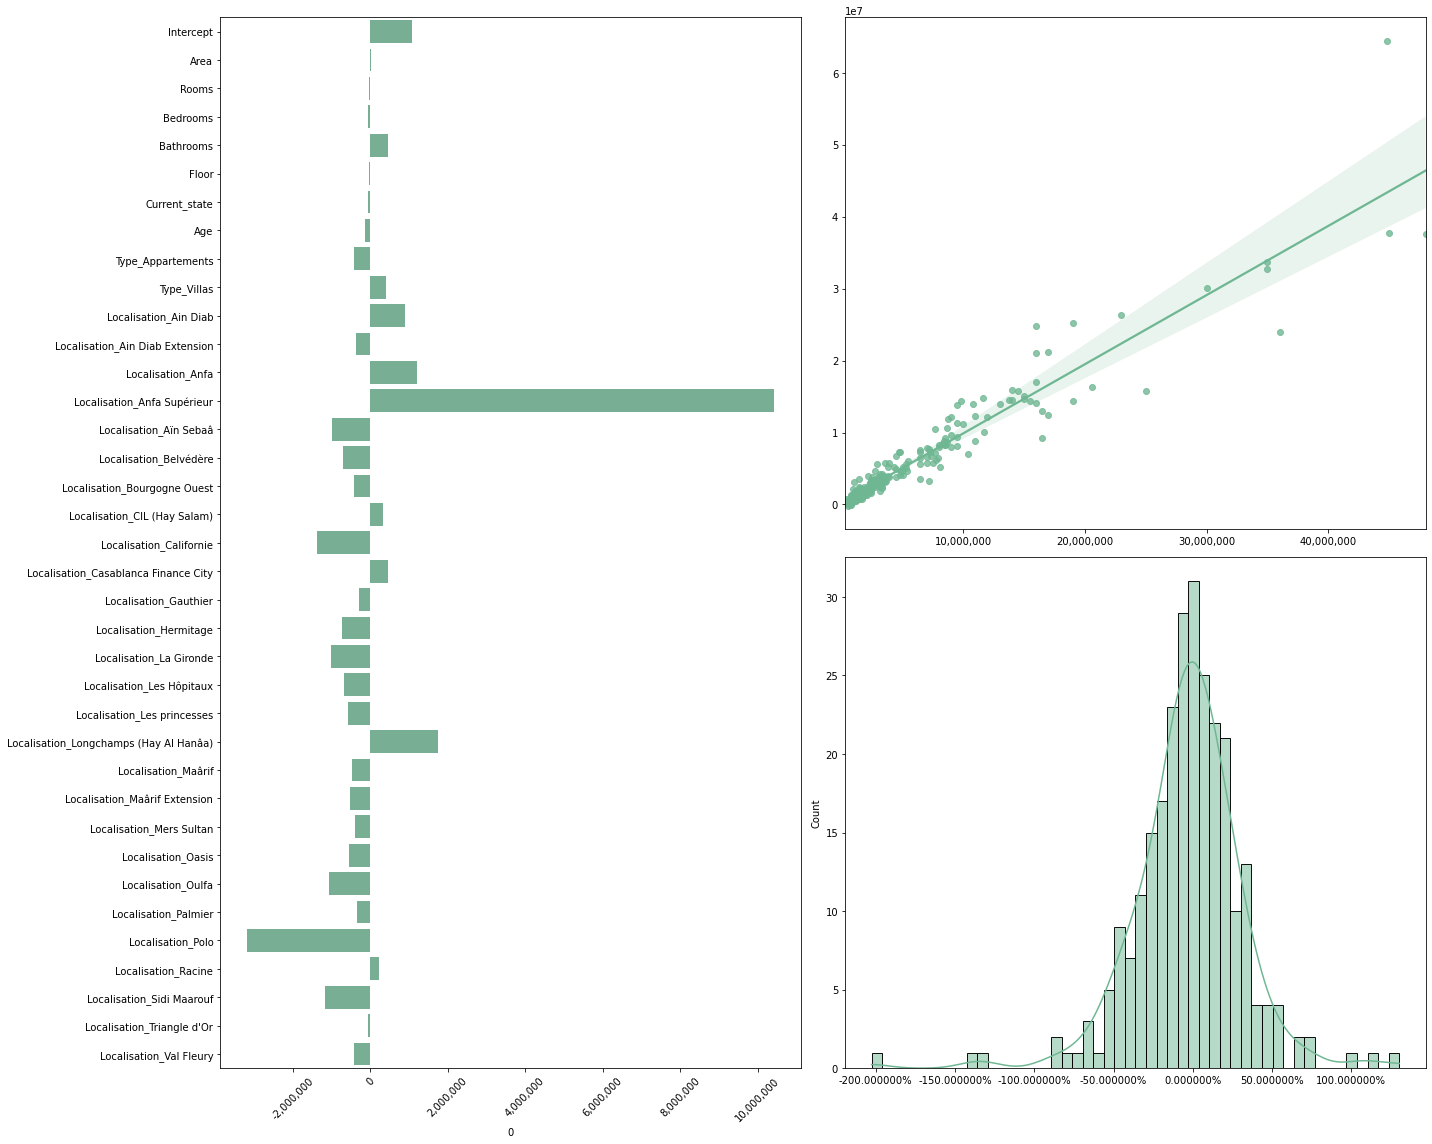

In [329]:
#Use a Ridge regression to introduce regularization
ridge = Ridge()
ridge_hyparams = {'alpha':[0.1,1,3,5]}
ridge_regression = GridSearchCV(ridge,ridge_hyparams,cv = 5)
evaluate_linear_model(X_train,y_train,X_test,y_test,ridge_regression,grid = True)

Best estimator parameters : {'alpha': 0.1}
train RMSE : 1977177.18
test RMSE : 2386857.86
train MAPE : 0.2208
test MAPE : 0.2568
Training set score (R^2): 0.94
Test set score (R^2): 0.89


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,...,Localisation_Maârif Extension,Localisation_Mers Sultan,Localisation_Oasis,Localisation_Oulfa,Localisation_Palmier,Localisation_Polo,Localisation_Racine,Localisation_Sidi Maarouf,Localisation_Triangle d'Or,Localisation_Val Fleury
0,2.739854e+06,3.998280e+06,-118040.771685,-134669.604875,473086.624803,-118878.027455,-47875.811996,-523603.540611,-415372.300908,415372.300908,...,-514850.924699,-400432.75493,-548557.044087,-1.052383e+06,-350213.513108,-3.184127e+06,225508.998751,-1.164940e+06,-66815.04567,-420126.484533


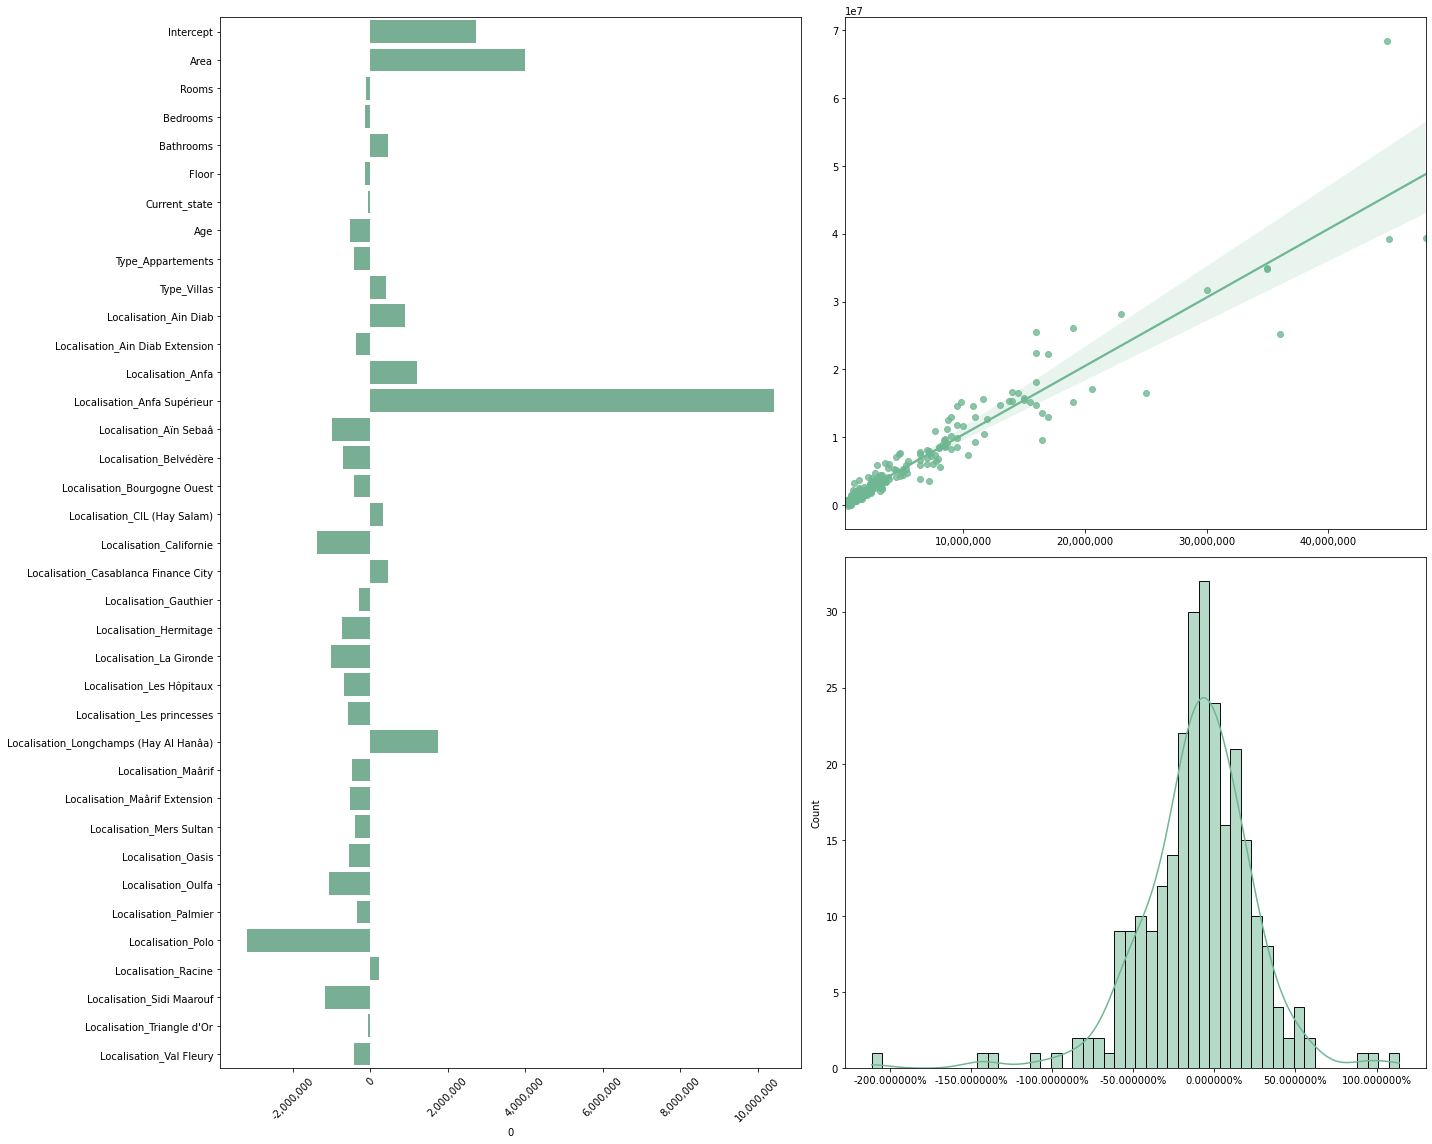

In [331]:
#Use a Ridge regression to introduce regularization with scaled data
evaluate_linear_model(X_train_scaled,y_train,X_test_scaled,y_test,ridge_regression,grid=True)

In [332]:
continuous_vars = ['Area','Rooms','Bedrooms','Bathrooms']

poly = PolynomialFeatures(degree = 2,include_bias = False)
poly = poly.fit(X[continuous_vars])
poly_df = pd.DataFrame(poly.transform(X[continuous_vars]),columns = poly.get_feature_names(continuous_vars))

In [333]:
X_poly = pd.concat([X_dummies,poly_df],axis=1)
X_poly.shape

(892, 50)

In [334]:
#split the data using the same random state for comparable results
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly,y,test_size = 0.3,random_state = 123)

In [335]:
scaler = RobustScaler()
X_train_poly_scaled = pd.DataFrame(scaler.fit_transform(X_train_poly),columns = X_train_poly.columns)
X_test_poly_scaled = pd.DataFrame(scaler.fit_transform(X_test_poly),columns = X_test_poly.columns)

train RMSE : 1865042.13
test RMSE : 2072937.85
train MAPE : 0.2294
test MAPE : 0.2552
Training set score (R^2): 0.95
Test set score (R^2): 0.92


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,...,Area^2,Area Rooms,Area Bedrooms,Area Bathrooms,Rooms^2,Rooms Bedrooms,Rooms Bathrooms,Bedrooms^2,Bedrooms Bathrooms,Bathrooms^2
0,2.546173e+06,2.664339e+06,288534.85041,235119.024055,-624534.198659,-19979.052199,-143422.742455,-647644.45368,-182318.519513,182318.519513,...,-94427.593662,207510.482154,-1.587822e+06,600732.043139,148215.351968,263752.590792,-1.451079e+06,-555047.960267,1.048742e+06,1.163664e+06


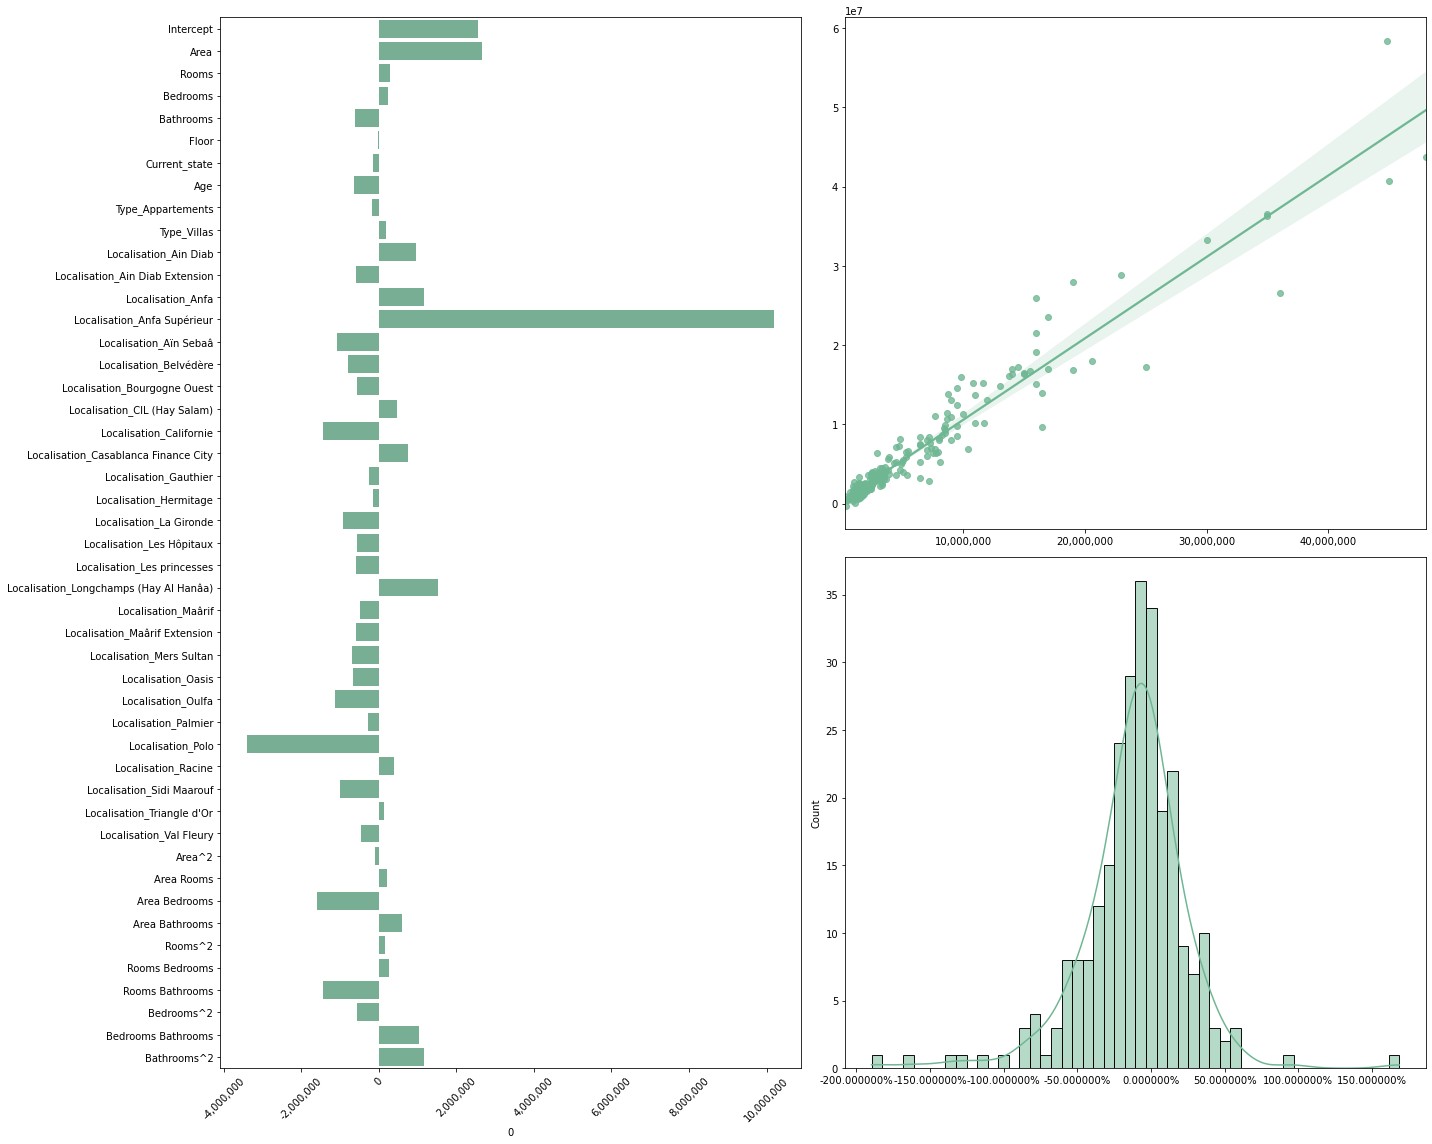

In [336]:
#Evaluate multivariate ols linear regression with polynomial features and feature scaling

poly_linear_regression = LinearRegression()
poly_linear_regression.fit(X_train_poly_scaled,y_train)

evaluate_linear_model(X_train_poly_scaled,y_train_poly,X_test_poly_scaled,y_test_poly,poly_linear_regression)

In [338]:
def evaluate_tree_model(X_train,y_train,X_test,y_test,reg,grid=False):
    
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)
    RMSE_error_train = np.sqrt(MSE(y_train,reg.predict(X_train)))
    RMSE_error = np.sqrt(MSE(y_test,y_pred))
    MAPE_train = np.median(MAPE(y_train,reg.predict(X_train),multioutput = 'raw_values'))
    MAPE_test = np.median(MAPE(y_test,y_pred, multioutput = 'raw_values'))
    
    if grid:
        print(f'Best estimator parameters : {reg.best_params_}')
        reg = reg.best_estimator_
        
    
    print(f'train RMSE : {RMSE_error_train:.2f}')
    print(f'test RMSE : {RMSE_error:.2f}')
    print(f'train MAPE : {MAPE_train:.4f}')
    print(f'test MAPE : {MAPE_test:.4f}')
    print(f'Training set score: {reg.score(X_train,y_train):.2f}')
    print(f'Test set score: {reg.score(X_test,y_test):.2f}')
    importances_matrix = pd.DataFrame(reg.feature_importances_.reshape(1,-1),columns = X_dummies.columns)
    display(importances_matrix)
    error_matrix = np.array([y_test,(y_test-y_pred)/y_test])
    
    fig,axes = plt.subplots(2,2,figsize = (20,16))
    
    ax1 = plt.subplot2grid((2,2),(0,0),rowspan=2)
    ax2 = plt.subplot2grid((2,2),(0,1),colspan = 1)
    ax3 = plt.subplot2grid((2,2),(1,1),colspan = 1)
    
    g = sns.barplot(y = importances_matrix.columns,x = importances_matrix.iloc[0,:] ,color = cust_pal[5],ax=ax1)
    ax1.tick_params('x',rotation = 45)
    
    g = sns.regplot(x = y_test,y = reg.predict(X_test),color = cust_pal[5],ax=ax2)
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(int(x),',')))
    
    g = sns.histplot(x = error_matrix[1,:],bins = 50,kde = True, color = cust_pal[5],ax = ax3)
    ax3.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(x,'%')))
    
    plt.tight_layout()
    plt.show()

Best estimator parameters : {'max_depth': 10, 'max_features': 15, 'n_estimators': 200}
train RMSE : 1040070.57
test RMSE : 1807021.38
train MAPE : 0.1073
test MAPE : 0.1882
Training set score: 0.98
Test set score: 0.94


,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,Localisation_Ain Diab,...,Localisation_Maârif Extension,Localisation_Mers Sultan,Localisation_Oasis,Localisation_Oulfa,Localisation_Palmier,Localisation_Polo,Localisation_Racine,Localisation_Sidi Maarouf,Localisation_Triangle d'Or,Localisation_Val Fleury
0,0.544764,0.037696,0.035832,0.039518,0.072583,0.008528,0.010635,0.100559,0.071575,0.003076,...,0.000009,0.000006,0.000823,0.00055,0.000018,0.00167,0.000573,0.005007,0.000075,0.000007


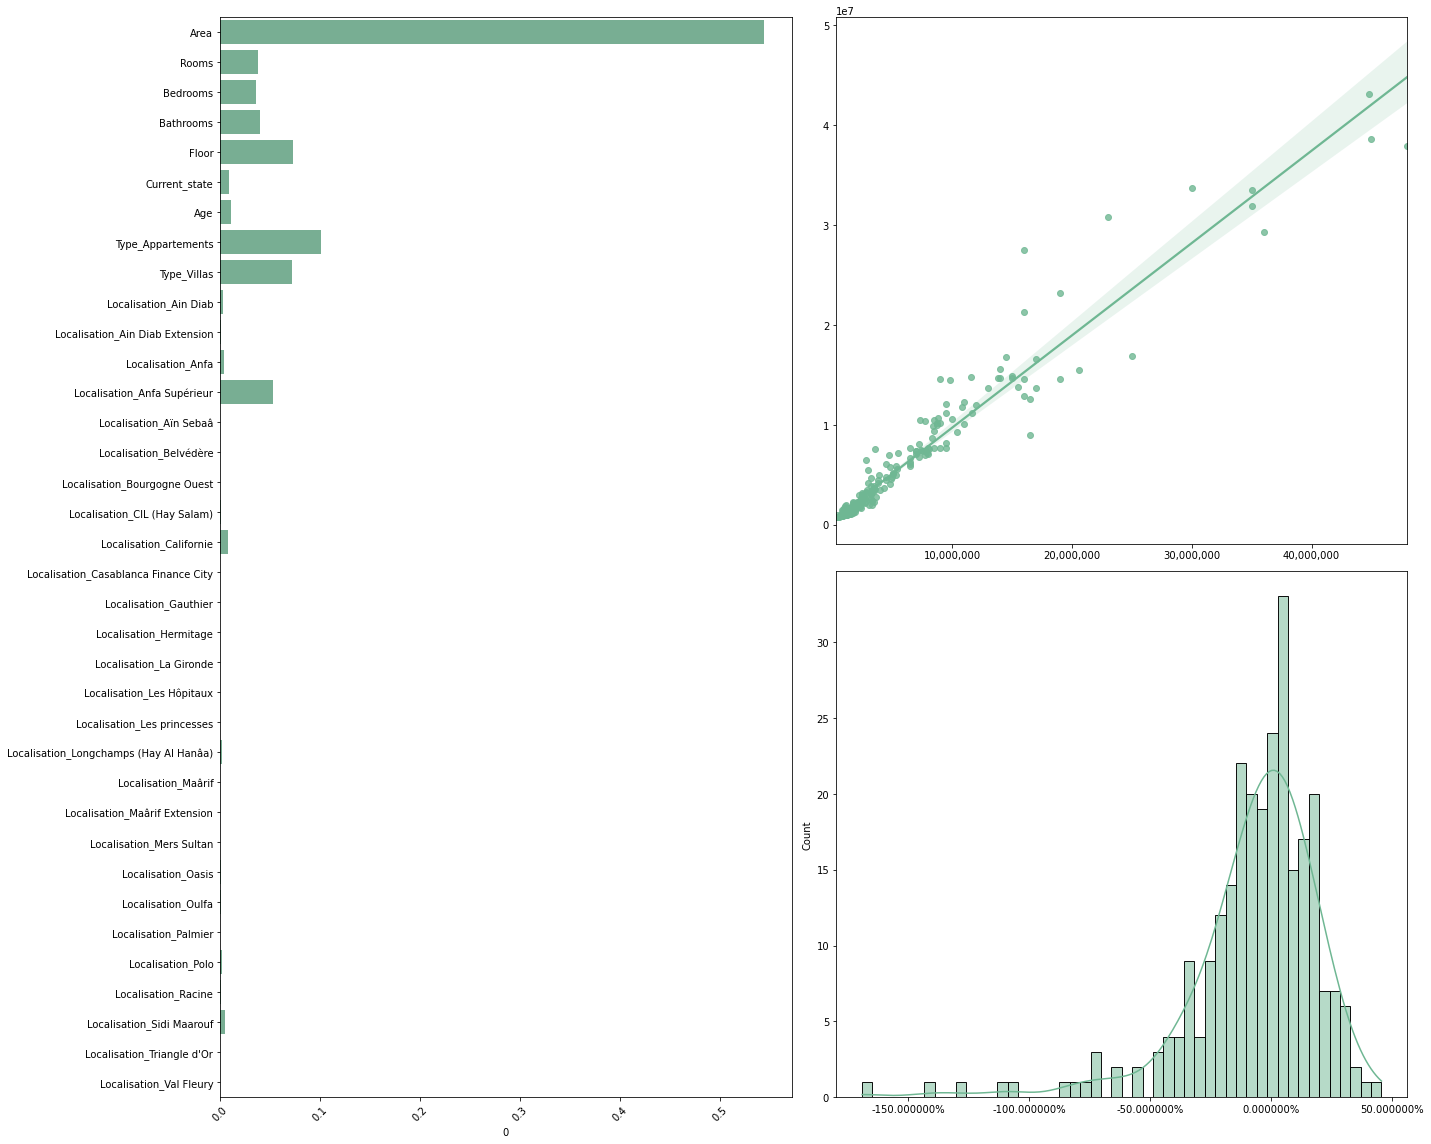

In [350]:
#Use a random forest regressor
rf = RandomForestRegressor(random_state = 123)
rf_hyparams = {'n_estimators' : [100,150,200],'max_depth' : [5,10],'max_features':[15]}
random_forest = GridSearchCV(rf,rf_hyparams,cv = 5)
evaluate_tree_model(X_train,y_train,X_test,y_test,random_forest,grid=True)

Best estimator parameters : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
train RMSE : 623311.00
test RMSE : 1789340.57
train MAPE : 0.1125
test MAPE : 0.1713
Training set score: 0.99
Test set score: 0.94


,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,Localisation_Ain Diab,...,Localisation_Maârif Extension,Localisation_Mers Sultan,Localisation_Oasis,Localisation_Oulfa,Localisation_Palmier,Localisation_Polo,Localisation_Racine,Localisation_Sidi Maarouf,Localisation_Triangle d'Or,Localisation_Val Fleury
0,0.913108,0.010235,0.001734,0.012034,0.002671,0.01351,0.005453,0.000311,0.004773,0.00079,...,0.0,0.0,0.00003,0.000224,0.0,0.00128,0.000546,0.00016,0.000056,0.0


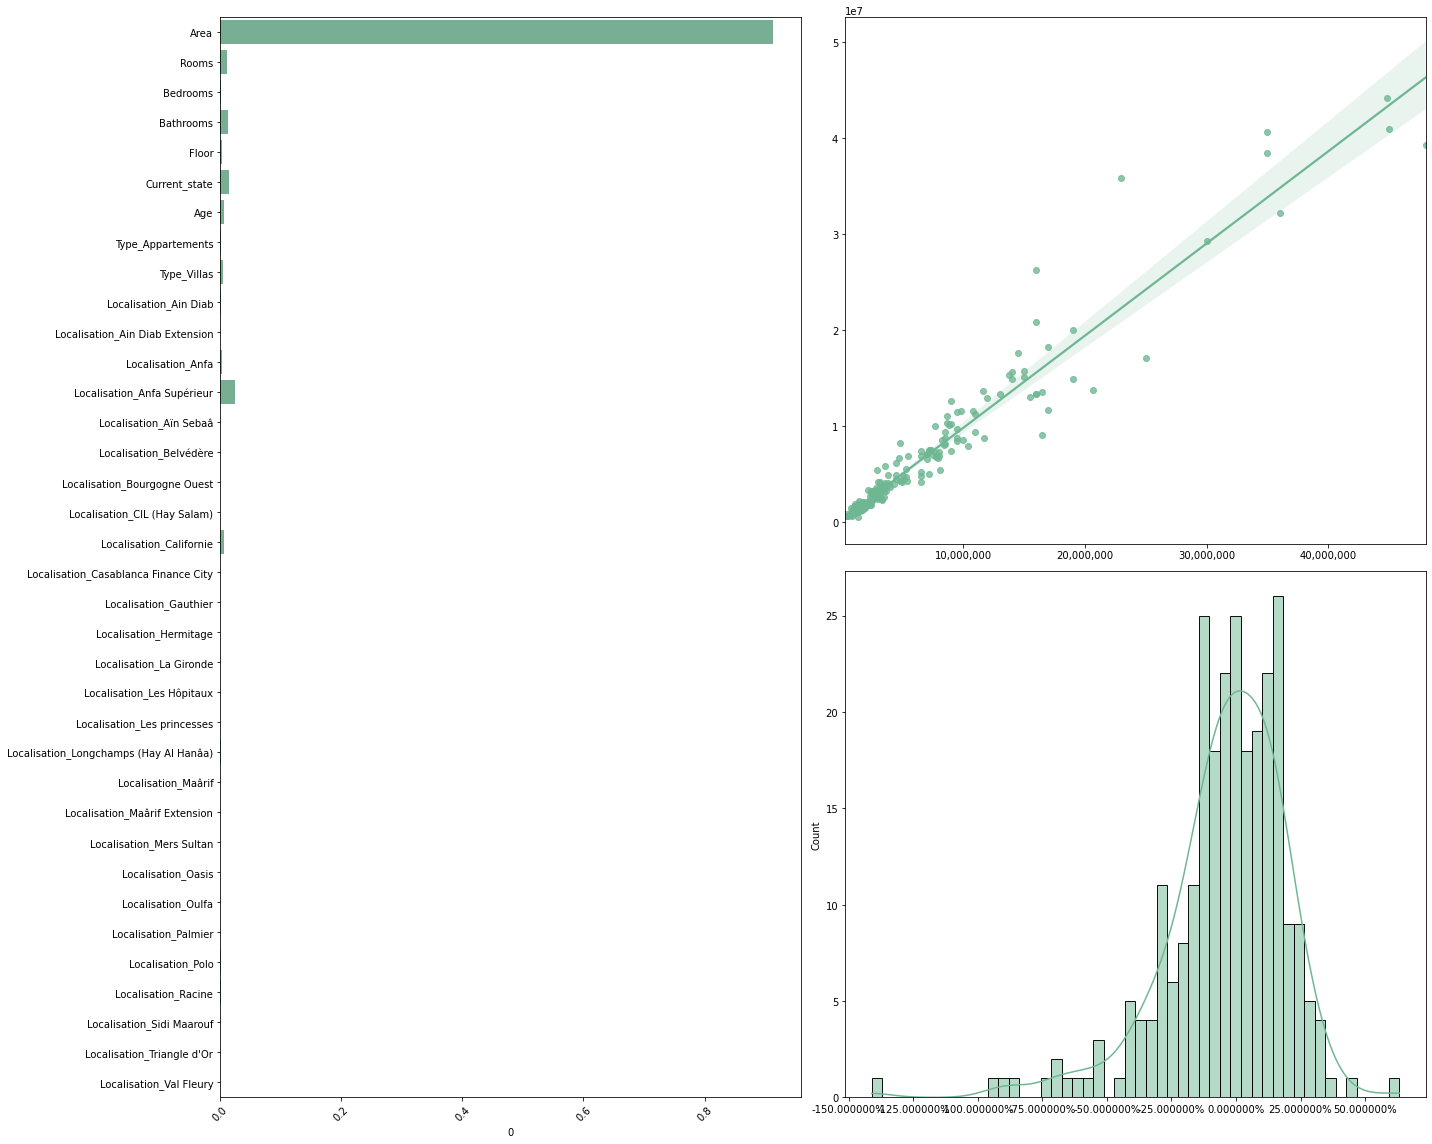

In [346]:
#Use a gradient boosting regressor
gb = GradientBoostingRegressor(random_state = 123)
gb_hyparams = {'n_estimators' : [10,50,100,200],'max_depth' : [3,5,10,15],'learning_rate':[0.05,0.1,0.5]}
gradient_boosted_regressor = GridSearchCV(gb,gb_hyparams,cv = 5)
evaluate_tree_model(X_train,y_train,X_test,y_test,gradient_boosted_regressor,grid=True)

### Build model for predicting Price_m2 

In [289]:
#Select columns to keep for modeling
cols_to_keep = ['Type','Localisation','Area','Rooms','Bedrooms','Bathrooms','Floor','Current_state','Age','Price_m2']
df_model = df[cols_to_keep]

In [290]:
#Data preprocessing : Missing values
display(df_model.isna().sum())

Type               0
Localisation       0
Area               0
Rooms              0
Bedrooms           0
Bathrooms          0
Floor              0
Current_state     37
Age              239
Price_m2           0
dtype: int64

In [291]:
#drop listings where all four continuous variables are missing
df_model = df_model.dropna(subset = ['Rooms','Bedrooms','Bathrooms','Floor']).reset_index(drop = True)

In [292]:
#Split dataframe into Features and Target Variable

features = ['Type','Localisation','Area','Rooms','Bedrooms','Bathrooms','Floor','Current_state','Age']
X = df_model[features]
y = df_model['Price_m2'].values 

In [293]:
#Encode ordinal variables

X.loc[:,'Current_state'] = X['Current_state'].replace(np.nan,0).replace('Nouveau',1).replace('Bon état',2).replace('À rénover',3)
X.loc[:,'Age'] = X['Age'].replace(np.nan,0).replace("Moins d'un an",1).replace("1-5 ans",2).replace("5-10 ans",3).replace("10-20 ans",4).replace("20-30 ans",5).replace("30-50 ans",6).replace("50-70 ans",7)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [294]:
#Encode categorical variables remaining
X_dummies = pd.get_dummies(X)

In [295]:
#Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_dummies,y,test_size = 0.3,random_state = 123)

In [296]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

train RMSE : 3033.22
test RMSE : 3265.04
train MAPE : 0.1523
test MAPE : 0.1625
Training set score (R^2): 0.53
Test set score (R^2): 0.46


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,...,Localisation_Maârif Extension,Localisation_Mers Sultan,Localisation_Oasis,Localisation_Oulfa,Localisation_Palmier,Localisation_Polo,Localisation_Racine,Localisation_Sidi Maarouf,Localisation_Triangle d'Or,Localisation_Val Fleury
0,20638.101379,-2.378921,-217.865901,-460.268203,499.395875,83.367353,-565.117995,-471.274722,-1867.202755,1867.202755,...,-456.142808,-752.116742,622.764017,-6710.426093,303.631377,-4614.851941,4637.313446,-2195.980158,2848.379679,-35.276764


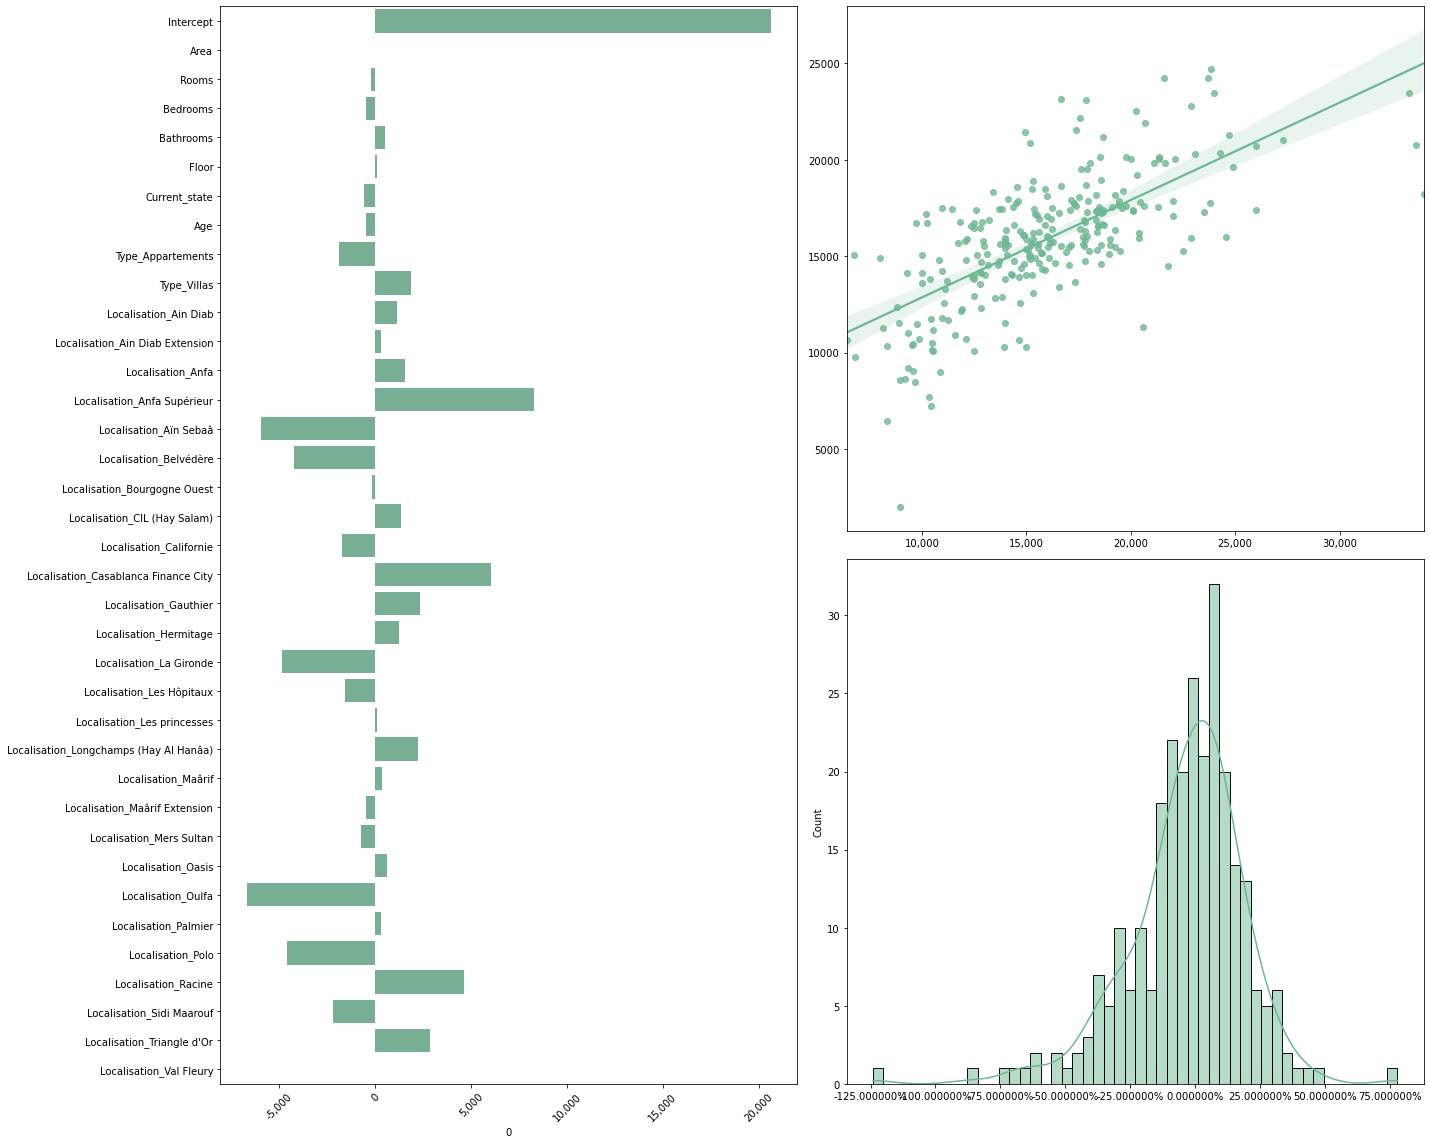

In [297]:
#Evaluate multivariate ols linear regression


reg = LinearRegression()
evaluate_linear_model(X_train,y_train,X_test,y_test,reg)

In [298]:
#Introduce polynomial features


In [299]:
#Encode categorical variables remaining
X_dummies = pd.get_dummies(X)

In [300]:
X_poly = pd.concat([X_dummies,poly_df],axis=1)
X_poly.shape

(892, 50)

In [301]:
#split the data using the same random state for comparable results
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly,y,test_size = 0.3,random_state = 123)

In [302]:
scaler = RobustScaler()
X_train_poly_scaled = pd.DataFrame(scaler.fit_transform(X_train_poly),columns = X_train_poly.columns)
X_test_poly_scaled = pd.DataFrame(scaler.fit_transform(X_test_poly),columns = X_test_poly.columns)

X_train_poly_scaled

,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,Localisation_Ain Diab,...,Area^2,Area Rooms,Area Bedrooms,Area Bathrooms,Rooms^2,Rooms Bedrooms,Rooms Bathrooms,Bedrooms^2,Bedrooms Bathrooms,Bathrooms^2
0,0.666140,1.25,0.5,1.0,-0.50,1.0,0.25,-1.0,1.0,1.0,...,0.681837,0.975669,0.657022,0.653474,1.625,1.315068,1.416667,0.583333,0.750,1.0
1,-0.249408,0.75,1.0,0.0,-0.50,0.0,-0.75,-1.0,1.0,0.0,...,-0.115337,-0.065195,-0.045189,-0.182058,0.825,1.260274,0.333333,1.333333,0.500,0.0
2,0.950276,0.50,0.5,0.0,-0.50,0.0,0.00,-1.0,1.0,0.0,...,1.138151,0.761484,0.891092,0.486368,0.500,0.657534,0.166667,0.583333,0.250,0.0
3,2.822415,0.50,1.0,3.0,-0.50,-1.0,-0.75,-1.0,1.0,0.0,...,6.618855,2.098450,3.118010,4.307828,0.500,0.986301,1.666667,1.333333,2.375,4.2
4,0.148382,1.50,0.0,1.0,1.50,-1.0,-0.25,0.0,0.0,0.0,...,0.104793,0.498450,0.096554,0.220756,2.100,0.986301,1.666667,0.000000,0.375,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,0.337806,0.75,0.5,2.0,0.25,-1.0,-0.50,0.0,0.0,0.0,...,0.277789,0.424049,0.386541,0.613017,0.825,0.876712,1.500000,0.583333,1.250,2.4
620,0.123125,0.00,0.0,1.0,1.00,0.0,0.25,0.0,0.0,0.0,...,0.085050,0.021982,0.080949,0.199648,0.000,0.000000,0.166667,0.000000,0.375,1.0
621,-0.148382,-0.25,-0.5,0.0,0.25,-1.0,-0.25,0.0,0.0,0.0,...,-0.077805,-0.149366,-0.159623,-0.125770,-0.175,-0.328767,-0.333333,-0.416667,-0.250,0.0
622,-0.214680,-0.25,0.0,-1.0,0.25,0.0,-0.25,0.0,0.0,0.0,...,-0.103846,-0.173039,-0.127763,-0.242744,-0.175,-0.164384,-0.583333,0.000000,-0.375,-0.6


train RMSE : 2874.70
test RMSE : 3429.27
train MAPE : 0.1460
test MAPE : 0.1669
Training set score (R^2): 0.58
Test set score (R^2): 0.41


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,...,Area^2,Area Rooms,Area Bedrooms,Area Bathrooms,Rooms^2,Rooms Bedrooms,Rooms Bathrooms,Bedrooms^2,Bedrooms Bathrooms,Bathrooms^2
0,13826.03948,-1665.241279,567.299327,-1332.721351,47.796254,474.414569,-456.570846,-1924.220876,-2780.772824,2780.772824,...,166.863945,984.593761,576.724866,-90.008858,97.199626,588.304698,-2996.118159,1950.376781,-1813.62786,2140.824548


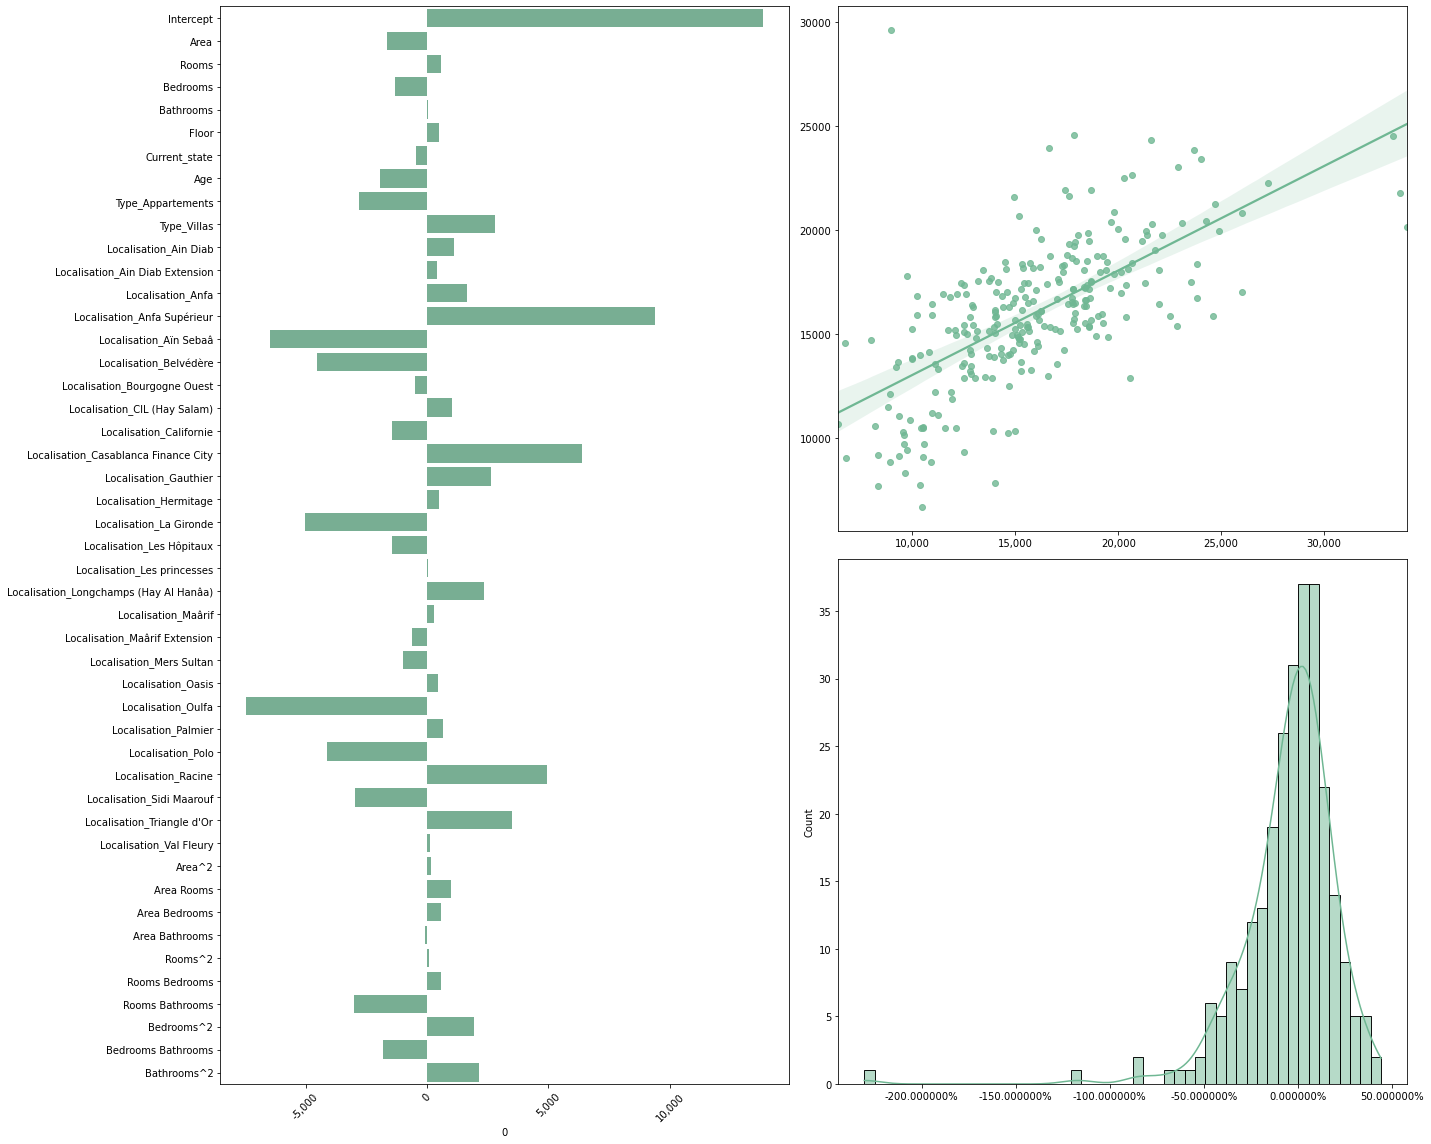

In [303]:
#Evaluate multivariate ols linear regression with polynomial features and feature scaling

reg = LinearRegression()
reg.fit(X_train_poly_scaled,y_train)

evaluate_linear_model(X_train_poly_scaled,y_train_poly,X_test_poly_scaled,y_test_poly,reg)

Best estimator parameters : {'max_depth': 10, 'max_features': 10, 'n_estimators': 200}
train RMSE : 2357.03
test RMSE : 3323.36
train MAPE : 0.1241
test MAPE : 0.1717
Training set score: 0.72
Test set score: 0.44


,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,Localisation_Ain Diab,...,Localisation_Maârif Extension,Localisation_Mers Sultan,Localisation_Oasis,Localisation_Oulfa,Localisation_Palmier,Localisation_Polo,Localisation_Racine,Localisation_Sidi Maarouf,Localisation_Triangle d'Or,Localisation_Val Fleury
0,0.168926,0.054022,0.040414,0.048112,0.043199,0.036038,0.087835,0.015766,0.010232,0.010883,...,0.002344,0.000403,0.0051,0.110959,0.000363,0.019623,0.085971,0.007405,0.0062,0.000539


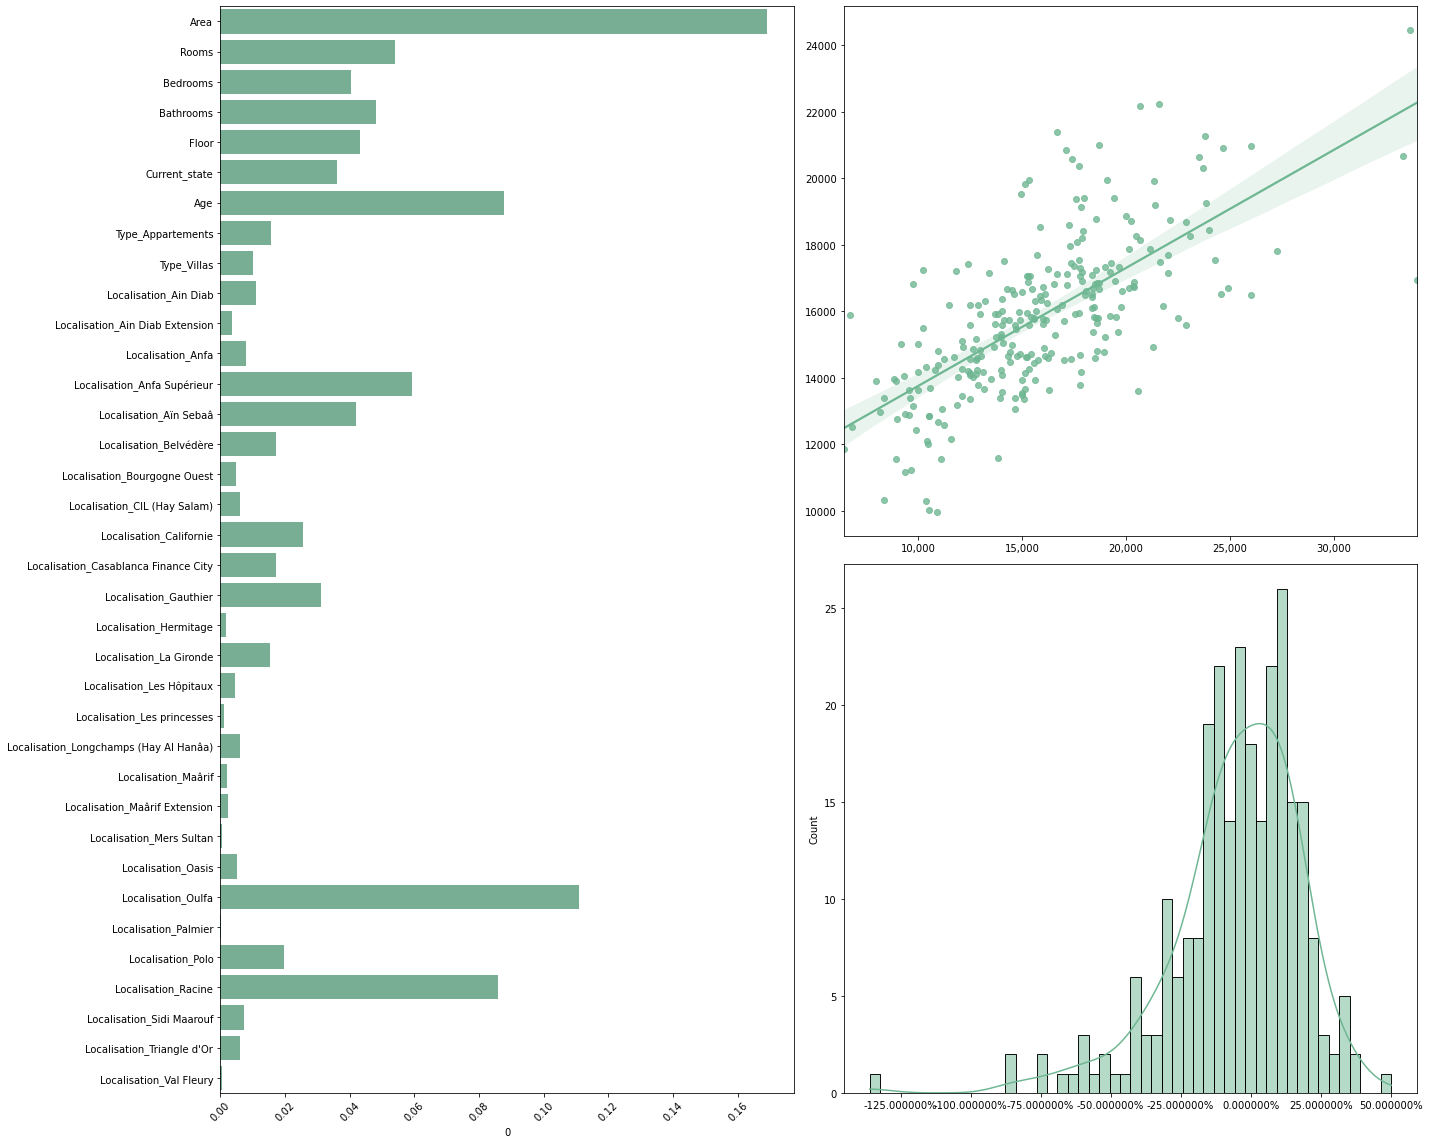

In [304]:
#Use a random forest regressor
rf = RandomForestRegressor()
rf_hyparams = {'n_estimators' : [10,50,100,200],'max_depth' : [5,10],'max_features':[10]}
reg = GridSearchCV(rf,rf_hyparams,cv = 5)
evaluate_tree_model(X_train,y_train,X_test,y_test,reg,grid=True)